In [1]:
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

            gdp_total_season_stdz  gdp_total_season_diff_stdz
1995-04-01               116624.0                   -0.103615
1995-07-01               114315.0                   -0.445386
1995-10-01               121939.0                    1.033835
1996-01-01               119460.0                   -0.470702
1996-04-01               121240.0                    0.163547
...                           ...                         ...
2023-01-01               197186.0                   -1.656701
2023-04-01               206848.0                    1.337334
2023-07-01               196434.0                   -1.652382
2023-10-01               206850.0                    1.449620
2024-01-01               195724.0                   -1.758413

[116 rows x 2 columns]


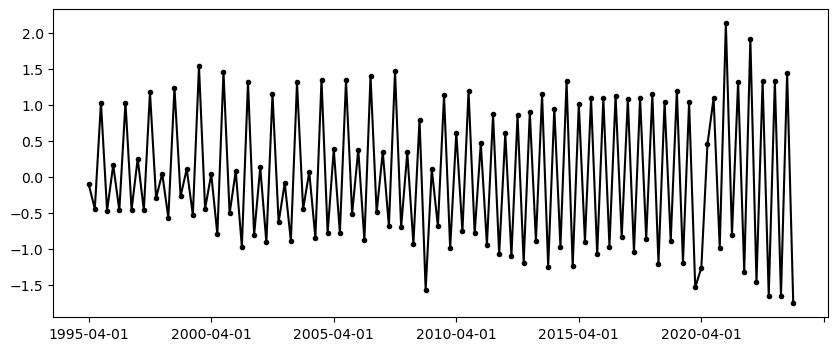

In [2]:
# get data     
data = pd.read_csv(r"../data/a0_combinedQuarterly_new.csv", index_col=[0])
data = data['gdp_total_season'].to_frame()
data['gdp_total_season_diff'] = data['gdp_total_season'].diff()
data.dropna(inplace=True)

scaler = StandardScaler()

columns_Transform = ["gdp_total_season_diff"]
data[columns_Transform] = scaler.fit_transform(data[columns_Transform])
data.columns = [cls + "_stdz" for cls in data.columns]
data['gdp_total_season_diff_stdz'].plot(style=".-", color="k", figsize=(10, 4));

y = data

print(y)

## Specify Model

In [3]:
## Set up a dictionary for the specification of our priors
## We set up the dictionary to specify size of the AR coefficients in
## case we want to vary the AR lags.

ar1_data = y['gdp_total_season_diff_stdz'].to_numpy()

priors = {
    "coefs": {"mu": [0, -0.6, 0.4], "sigma": [0.3, 0.3, 0.3], "size": 3},
    "sigma": 10,
    "init": {"mu": 0, "sigma": 0.1, "size": 1},
}

## Initialise the model
with pm.Model() as AR:
    pass

## Define the time interval for fitting the data
t_data = list(range(len(ar1_data)))
## Add the time interval as a mutable coordinate to the model to allow for future predictions
AR.add_coord("obs_id", t_data, mutable=True)

with AR:
    ## Data containers to enable prediction
    t = pm.MutableData("t", t_data, dims="obs_id")
    y = pm.MutableData("y", ar1_data, dims="obs_id")

    # The first coefficient will be the constant term but we need to set priors for each coefficient in the AR process
    coefs = pm.Normal("coefs", priors["coefs"]["mu"], priors["coefs"]["sigma"])
    sigma = pm.HalfNormal("sigma", priors["sigma"])
    # We need one init variable for each lag, hence size is variable too
    init = pm.Normal.dist(
        priors["init"]["mu"], priors["init"]["sigma"], size=priors["init"]["size"]
    )
    # Steps of the AR model minus the lags required
    ar1 = pm.AR(
        "ar",
        coefs,
        sigma=sigma,
        init_dist=init,
        constant=True,
        steps=t.shape[0] - (priors["coefs"]["size"] - 1),
        dims="obs_id",
    )

    # The Likelihood
    outcome = pm.Normal("likelihood", mu=ar1, sigma=sigma, observed=y, dims="obs_id")
    ## Sampling
    idata_ar = pm.sample_prior_predictive()
    idata_ar.extend(pm.sample(2000, random_seed=100, target_accept=0.95))
    idata_ar.extend(pm.sample_posterior_predictive(idata_ar))

/home/jpp/miniconda3/envs/pymc_env/lib/python3.12/site-packages/pymc/model/core.py:999: FutureWarning: Coords are now always mutable. Specifying `mutable` will raise an error in a future release
  warnings.warn(
/home/jpp/miniconda3/envs/pymc_env/lib/python3.12/site-packages/pymc/data.py:304: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Sampling: [ar, coefs, likelihood, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [coefs, sigma, ar]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 28 seconds.
Sampling: [likelihood]


Output()

In [4]:
idata_ar

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

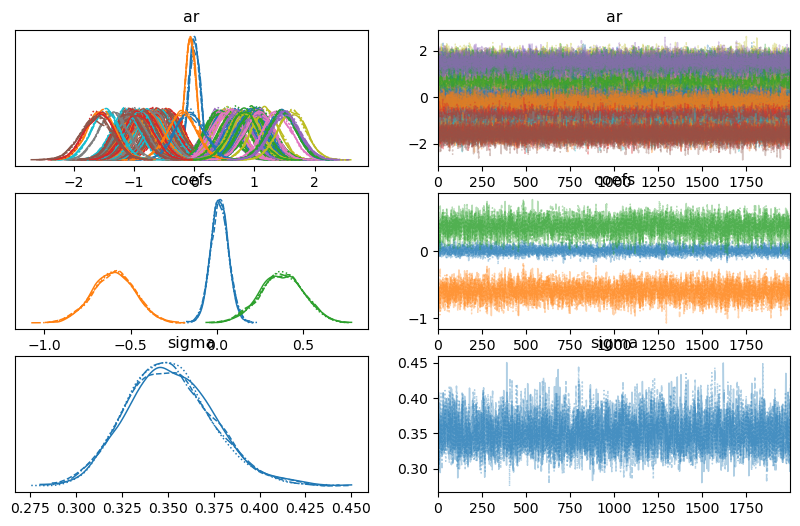

In [5]:
az.plot_trace(idata_ar, figsize=(10, 6));

In [6]:
az.summary(idata_ar, var_names=["~ar"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
coefs[0],0.015,0.052,-0.085,0.111,0.001,0.000,6331.0,6482.0,1.0
coefs[1],-0.598,0.122,-0.832,-0.374,0.002,0.001,4325.0,6026.0,1.0
coefs[2],0.374,0.126,0.133,0.609,0.002,0.001,4062.0,5668.0,1.0
sigma,0.351,0.024,0.307,0.394,0.000,0.000,3668.0,5511.0,1.0


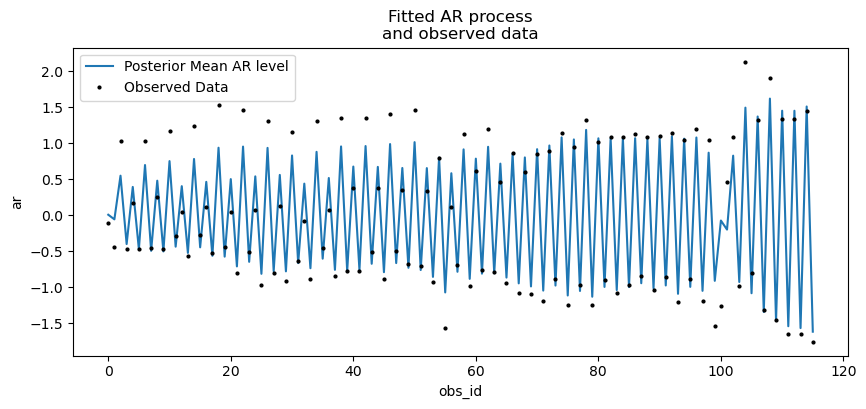

In [7]:
fig, ax = plt.subplots(figsize=(10, 4))
idata_ar.posterior.ar.mean(["chain", "draw"]).plot(ax=ax, label="Posterior Mean AR level")
ax.plot(ar1_data, "o", color="black", markersize=2, label="Observed Data")
ax.legend()
ax.set_title("Fitted AR process\nand observed data");

In [8]:
idata_ar

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

In [9]:
prediction_length = 16
n = prediction_length - ar1_data.shape[0]
obs = list(range(prediction_length))
with AR:
    ## We need to have coords for the observations minus the lagged term to correctly centre the prediction step
    AR.add_coords({"obs_id_fut_1": range(ar1_data.shape[0] - 1, 16, 1)})
    AR.add_coords({"obs_id_fut": range(ar1_data.shape[0], 16, 1)})
    # condition on the learned values of the AR process
    # initialise the future AR process precisely at the last observed value in the AR process
    # using the special feature of the dirac delta distribution to be 0 everywhere else.
    ar1_fut = pm.AR(
        "ar1_fut",
        init_dist=pm.DiracDelta.dist(ar1[..., -1]),
        rho=coefs,
        sigma=sigma,
        constant=True,
        dims="obs_id_fut_1",
    )
    yhat_fut = pm.Normal("yhat_fut", mu=ar1_fut[1:], sigma=sigma, dims="obs_id_fut")
    # use the updated values and predict outcomes and probabilities:
    idata_preds = pm.sample_posterior_predictive(idata_ar, var_names=["likelihood", "yhat_fut"], predictions=True, random_seed=100)

Sampling: [ar1_fut, likelihood, yhat_fut]


Output()

AssertionError: `x[i]` and `y` do not have the same shape.
Apply node that caused the error: Assert{msg='`x[i]` and `y` do not have ...'}(Subtensor{i}.0, Composite{...}.2)
Toposort index: 11
Inputs types: [TensorType(float64, shape=()), TensorType(bool, shape=())]
Inputs shapes: [(), ()]
Inputs strides: [(), ()]
Inputs values: [array(-1.8413714), array(False)]
Outputs clients: [[SetSubtensor{:stop}(AllocEmpty{dtype='float64'}.0, Assert{msg='`x[i]` and `y` do not have ...'}.0, 2)]]

HINT: Re-running with most PyTensor optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the PyTensor flag 'optimizer=fast_compile'. If that does not work, PyTensor optimizations can be disabled with 'optimizer=None'.
HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.